Fixed probability counter : 1 / 16 : aula 09

Space-Saving Count : aula 11

- https://www.vldb.org/pvldb/vol15/p1215-zhao.pdf

- All items whose true count is > n / k are stored ! : n = total number of items, k = number of counters (k = 20 n chega)

- Smallest count min cannot be larger than ε × n: IMPLICA AUMENTAR O K ? SIM!!!!

In [96]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [97]:
class SpaceSavingCounter:
    """
    A class to implement the Space-Saving algorithm for approximate counting of elements.

    Attributes:
    -----------
    k : int
        The maximum number of elements to keep track of.
    table : dict
        A dictionary to store elements and their approximate counts.

    Methods:
    --------
    __init__(k):
        Initializes the SpaceSavingCounter with a specified maximum number of elements.
    
    process(element):
        Processes an element by either incrementing its count if it exists in the table,
        adding it to the table if there is space, or evicting the element with the smallest
        count and inserting the new element with an incremented count.
    
    get_counts():
        Returns the current table of elements and their approximate counts.
    """
    def __init__(self, k):
        self.k = k
        self.table = {}  

    def process(self, element):
        # If element is already in the table, increment its count
        if element in self.table:
            self.table[element] += 1
        else:
            # If there is space in the table, add the element with count 1
            if len(self.table) < self.k:
                self.table[element] = 1
            else:
                # If the table is full, find the element with the smallest count
                min_element = min(self.table, key=self.table.get)
                min_count = self.table[min_element]
                # Evict the element with the smallest count and insert the new element
                del self.table[min_element]  # Remove the element with the smallest count
                self.table[element] = min_count + 1  # Insert the new element with incremented count

    def get_counts(self):
        return self.table

In [98]:
def count_words(book, use_exact=True, use_approximate=True, use_space_saving=True):
    with open(book, "r") as f:
        text = f.read()
    words = text.split()

    exact_counter = {}
    approximate_counter = {}
    space_saving5 = SpaceSavingCounter(5)
    space_saving10 = SpaceSavingCounter(10)
    space_saving15 = SpaceSavingCounter(50)
    for word in words:

        if use_exact:
            # exact counter
            if word in exact_counter:
                exact_counter[word] += 1
            else:
                exact_counter[word] = 1

        if use_approximate:
            # approximate counter with 1/16 probability
            if random.random() < 1/16:
                if word in approximate_counter:
                    approximate_counter[word] += 1
                else:
                    approximate_counter[word] = 1
            else:
                pass

        if use_space_saving:
            # data stream: Space-Saving Count
            space_saving5.process(word)
            space_saving10.process(word)
            space_saving15.process(word)
        
    exact_counter = {k: v for k, v in sorted(exact_counter.items(), key=lambda item: item[1], reverse=True)}
    approximate_counter = {k: v*16 for k, v in sorted(approximate_counter.items(), key=lambda item: item[1], reverse=True)}
    return (exact_counter,
            approximate_counter,
            space_saving5.get_counts(),
            space_saving10.get_counts(),
            space_saving15.get_counts())

In [99]:
#exactEN, approximateEN, ss5, ss10, ss15 = count_words("books/pinocchio_en.txt", use_exact=True, use_approximate=True, use_space_saving=True)
#exactIT, approximateIT, ss5, ss10, ss15 = count_words("books/pinocchio_it.txt", use_exact=True, use_approximate=True, use_space_saving=True)
#exactFI, approximateFI, ss5, ss10, ss15 = count_words("books/pinocchio_fi.txt", use_exact=True, use_approximate=True, use_space_saving=True)

exact counters

In [100]:
if False:
    df_exact = {("EN", "word"): [],
                ("EN", "count"): [],
                ("IT", "word"): [],
                ("IT", "count"): [],
                ("FI", "word"): [],
                ("FI", "count"): []}

    for k, v in exactEN.items():
        df_exact[("EN", "word")].append(k)
        df_exact[("EN", "count")].append(int(v))

    for k, v in exactIT.items():
        df_exact[("IT", "word")].append(k)
        df_exact[("IT", "count")].append(int(v))

    for k, v in exactFI.items():
        df_exact[("FI", "word")].append(k)
        df_exact[("FI", "count")].append(int(v))

    total_rows = max(len(df_exact[("EN", "word")]), len(df_exact[("IT", "word")]), len(df_exact[("FI", "word")]))
    for i in range(total_rows):
        if i >= len(df_exact[("EN", "word")]):
            df_exact[("EN", "word")].append(np.nan)
            df_exact[("EN", "count")].append(np.nan)
        if i >= len(df_exact[("IT", "word")]):
            df_exact[("IT", "word")].append(np.nan)
            df_exact[("IT", "count")].append(np.nan)
        if i >= len(df_exact[("FI", "word")]):
            df_exact[("FI", "word")].append(np.nan)
            df_exact[("FI", "count")].append(np.nan)

    df_exact = pd.DataFrame(df_exact)
    df_exact.to_excel("results/exact_counts.xlsx")
    print("Exact counts saved to results/exact_counts.xlsx")

probabilistic counters

In [101]:
if False:
    df_prob = {}
    for _ in range(20):
        df_prob[("EN", f"word_{_}")] = []
        df_prob[("EN", f"count_{_}")] = []
        df_prob[("IT", f"word_{_}")] = []
        df_prob[("IT", f"count_{_}")] = []
        df_prob[("FI", f"word_{_}")] = []
        df_prob[("FI", f"count_{_}")] = []

        exactEN, approximateEN, ss5, ss10, ss15 = count_words("books/pinocchio_en.txt", use_exact=False, use_approximate=True, use_space_saving=False)
        exactIT, approximateIT, ss5, ss10, ss15 = count_words("books/pinocchio_it.txt", use_exact=False, use_approximate=True, use_space_saving=False)
        exactFI, approximateFI, ss5, ss10, ss15 = count_words("books/pinocchio_fi.txt", use_exact=False, use_approximate=True, use_space_saving=False)

        for k, v in approximateEN.items():
            df_prob[("EN", f"word_{_}")].append(k)
            df_prob[("EN", f"count_{_}")].append(int(v))
        
        for k, v in approximateIT.items():
            df_prob[("IT", f"word_{_}")].append(k)
            df_prob[("IT", f"count_{_}")].append(int(v))
        
        for k, v in approximateFI.items():
            df_prob[("FI", f"word_{_}")].append(k)
            df_prob[("FI", f"count_{_}")].append(int(v))
    
    total_rows = 0
    for k in df_prob.keys():
        total_rows = max(total_rows, len(df_prob[k]))
    for k in df_prob.keys():
        for i in range(total_rows):
            if i >= len(df_prob[k]):
                df_prob[k].append(np.nan)
    df_prob = pd.DataFrame(df_prob)

    order_h0 = ["EN", "IT", "FI"]
    order_h1 = [(f"word_{_}", f"count_{_}") for _ in range(20)]
    order = []
    for h0 in order_h0:
        for h1w, h1c in order_h1:
            order.append((h0, h1w))
            order.append((h0, h1c))
    df_prob = df_prob[order]
    df_prob.to_excel("results/approximate_counts.xlsx")
    print("Approximate counts saved to results/approximate_counts.xlsx")

space-saving counters

In [102]:
17131/209

17131/50

342.62

In [103]:
a, a, ss5EN, ss10EN, ss50EN = count_words("books/pinocchio_en.txt", use_exact=False, use_approximate=False, use_space_saving=True)
# Total number of words in the book: 17131

ss50EN

{'pinocchio': 457,
 'little': 341,
 'say': 344,
 'snail': 341,
 'fairy': 341,
 'good': 341,
 'papa': 340,
 'old': 340,
 'geppetto': 341,
 'head': 340,
 'arm': 340,
 'cover': 339,
 'kiss': 339,
 'sudden': 340,
 'change': 341,
 'account': 340,
 'home': 340,
 'answer': 341,
 'boy': 341,
 'behave': 341,
 'badly': 340,
 'turn': 341,
 'new': 340,
 'leaf': 340,
 'power': 340,
 'bring': 340,
 'contentment': 340,
 'happiness': 340,
 'family': 340,
 'wooden': 340,
 'hide': 340,
 'point': 340,
 'big': 340,
 'puppet': 341,
 'lean': 340,
 'chair': 340,
 'dangle': 340,
 'leg': 340,
 'crossed': 340,
 'bend': 340,
 'miracle': 340,
 'remain': 340,
 'stand': 340,
 'look': 341,
 'short': 340,
 'time': 340,
 'great': 340,
 'complacency': 340,
 'ridiculous': 340,
 'glad': 340}

In [104]:
def space_saving_only(book, k):
    with open(book, "r") as f:
        text = f.read()
    words = text.split()
    n = len(words)

    space_saving = SpaceSavingCounter(k)
    for word in words:

        # data stream: Space-Saving Count
        space_saving.process(word)
        
    return (list(space_saving.get_counts().values()), n)

In [105]:
ss, n = space_saving_only("books/pinocchio_en.txt", 4)
#4282.75

ss

[4282, 4283, 4283, 4283]

fazer em % a qnt de k pq é normal ser maior e tal, mas meter o grafico a explicar, posso meter o k = 5 para mostrar os maus resultados e tal e dps meto o grafico e mostro a escolha e tudo mais bla bla

mesmo q use tp k= 80, posso so meter top 10

talvez tenha de usar em vez de  // e // +1, algo tp % pq o de 40 da mal

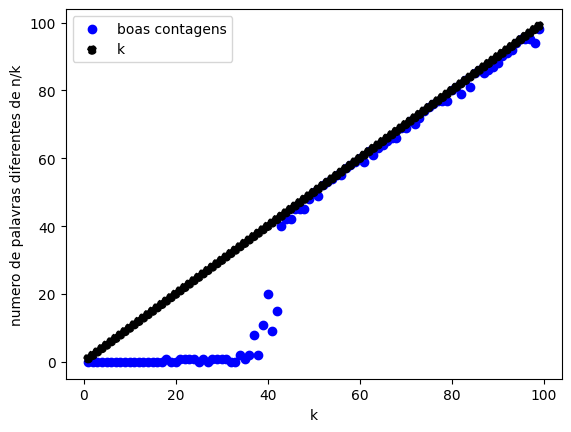

In [108]:
# ver a que partir de k se comeca a ter precisao
plot1_y = []

for k in range(1, 100):
    ss, n = space_saving_only("books/pinocchio_en.txt", k)
    mas_contagens = ss.count(n//k) + ss.count(n//k + 1)
    # plot1
    plot1_y.append(len(ss) - mas_contagens)

plt.scatter(range(1,100),plot1_y, color="blue", label = "boas contagens")
plt.scatter(range(1,100),range(1,100), color="black", linestyle="--", label = "k")

plt.legend()
plt.ylabel("numero de palavras diferentes de n/k")
plt.xlabel("k")
plt.show()

---

usar este ou parecido para comparar os bytes, talvez ate possa usar os execel do results para isso

In [107]:
import sys
size = sys.getsizeof(exactEN)
print(f"Memory size of x: {size} bytes")

NameError: name 'exactEN' is not defined